# Intel Images Classification using VGG-19

# Prepare Dataset and dependencies

## Installing Dependencies


In [1]:
!pip install wandb

## Import Library

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from wandb.integration.keras import WandbMetricsLogger
import wandb

In [ ]:
wandb.login(key="")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data Preprocessing

## Load Dataset

In [4]:
class_names = os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")
print(len(class_names))

6


### Configuration

In [5]:
config = {
    "BATCH_SIZE" :64,
    "IMG_SIZE":150,
    "VAL_SPLIT":0.1,
    "EPOCHS":100,
    "PATIENCE":5
}

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    shuffle=True,
    seed=32,
    validation_split=config["VAL_SPLIT"],
    subset="training",
    interpolation="bilinear",
    verbose=True
)

# Create validation dataset
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    shuffle=True,
    seed=32,
    validation_split=config["VAL_SPLIT"],
    subset="validation",
    interpolation="bilinear",
    verbose=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_test/seg_test",
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    interpolation='bilinear',
    verbose=True
)

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.


## Visualize Distribution

In [7]:

def get_data_distribution(dataset=[]):
  labels = []
  for data in dataset:
    for _,label in data:
      labels.extend(tf.argmax(label,axis=1).numpy())
  y, idx, count = tf.unique_with_counts(labels)
  return y, count



def visualize_data(class_data,count):
  plt.figure(figsize=(10,10))
  plt.bar(class_data,count,align="center")
  plt.tight_layout()
  plt.title("Class Distribution")
  plt.ylabel("Number of Data")
  plt.xlabel("Class in number")
  plt.show()


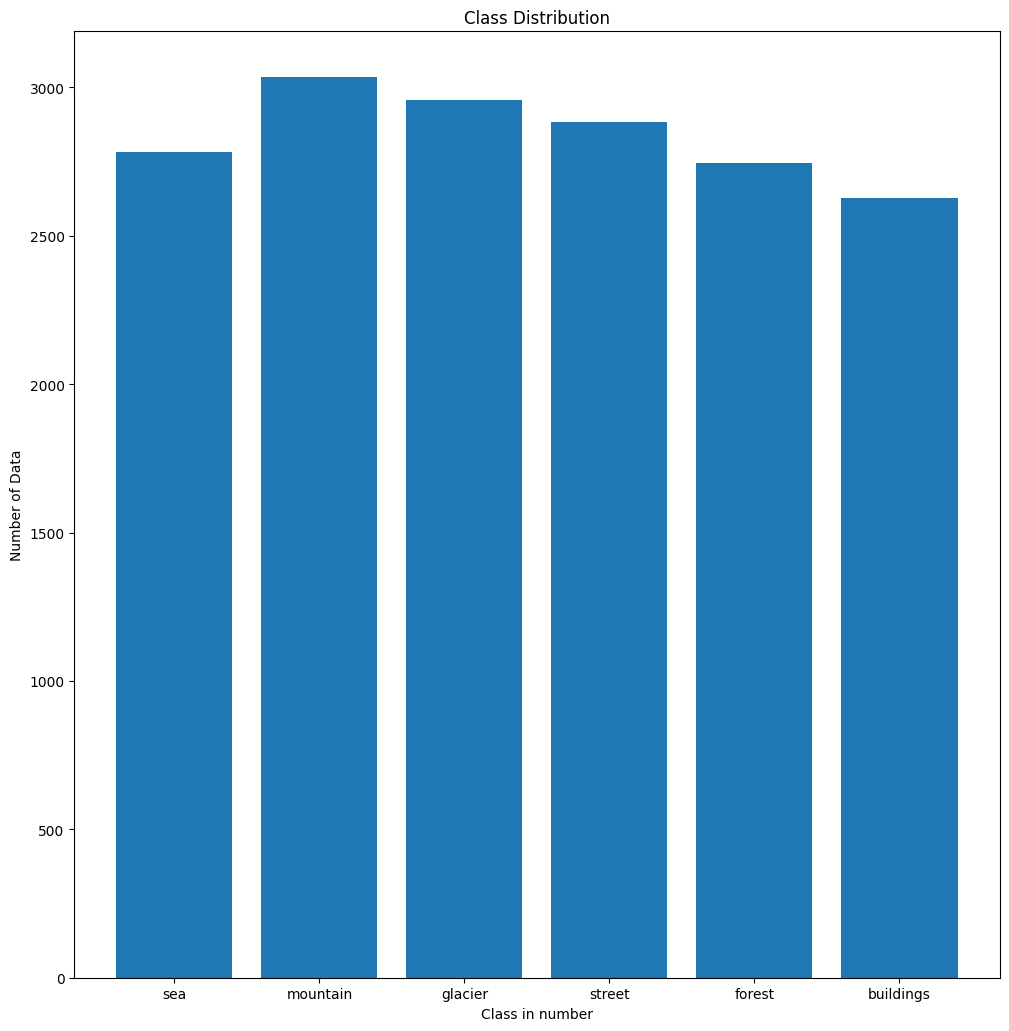

In [8]:
class_data, counts = get_data_distribution([train_dataset,valid_dataset,test_dataset])
visualize_data([class_names[cd] for cd in class_data],counts.numpy())

In [9]:
for i,_ in enumerate(class_data):
  print(f"{class_names[class_data[i]]} : {counts[i]}")

sea : 2784
mountain : 3037
glacier : 2957
street : 2883
forest : 2745
buildings : 2628


## Visualize Sample Image

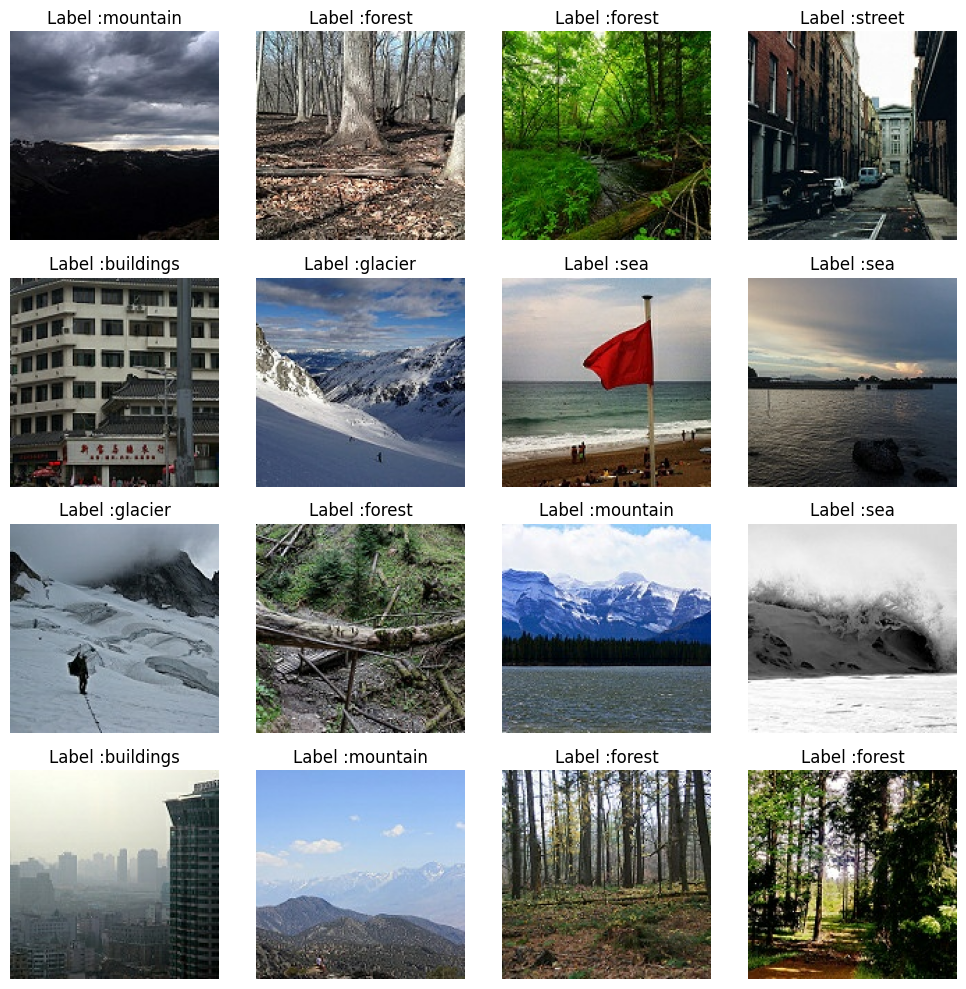

In [10]:
plt.figure(figsize=(10,10))
for img,label in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(f"Label :{class_names[tf.argmax(label[i])]}")
    plt.axis(False)
plt.tight_layout()
plt.show()

## Data Augmentation

In [11]:
def image_augmentation(img,label):
  img = tf.image.flip_left_right(img)
  img = tf.image.random_brightness(img, max_delta=0.2)
  img =tf.image.random_contrast(img,lower=0.8, upper=1.2)
  img = normalize_img(img,label)
  return img,label

def normalize_img(img,label):
  img = tf.cast(img,tf.float32)/255.0
  return img,label

In [12]:
train_dataset = (train_dataset.map(lambda img,label : image_augmentation(img,label))
                  .prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.map(lambda img,label:normalize_img(img,label))
              .prefetch(tf.data.AUTOTUNE))
test_data = (
            test_dataset.map(lambda img,label:normalize_img(img,label))

            .prefetch(tf.data.AUTOTUNE)
)

## Building Model VGG19

In [13]:
class VGG19(tf.keras.Model):
  def __init__(self,input_shape,output_shape,**kwargs):
    super().__init__(**kwargs)
    self.conv_blocks=[
        self._conv_block(64,2),
        self._conv_block(128,2),
        self._conv_block(256,4),
        self._conv_block(512,4),
        self._conv_block(512,4),
    ]
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units=4096,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.0005))
    self.dropout1 = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(units=4096,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.0005))
    self.dropout2 = tf.keras.layers.Dropout(0.5)
    self.output_layer = tf.keras.layers.Dense(units=output_shape,activation="softmax")

  def _conv_block(self,filters,num_layers):
    block = tf.keras.Sequential()
    for _ in range(num_layers):
      block.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), activation="relu",padding="same"))
    block.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    return block

  def call(self,inputs,training=False):
    x = inputs
    for block in self.conv_blocks:
      x = block(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dropout1(x,training=training)
    x = self.dense2(x)
    x= self.dropout2(x)
    x = self.output_layer(x)
    return x


### Define Callbacks and Wandb

In [14]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=config["PATIENCE"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_cb.keras",save_best_only=True)
logs = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [15]:
# Initialize wandb
run = wandb.init(
    project="vgg19-intel-scratch",
    config=config,
)

wandb: Currently logged in as: fadhilelrizandamicr (fe-org). Use `wandb login --relogin` to force relogin


## Training Model

### Training With Distributed GPU

In [16]:
import tensorflow as tf

# Configure MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Print the number of GPUs being used
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

# Build and compile the model within the strategy scope
with strategy.scope():
    VGG_model = VGG19((config["IMG_SIZE"],config["IMG_SIZE"],3),len(class_names))
    VGG_model(tf.keras.layers.Input(shape=(config["IMG_SIZE"],config["IMG_SIZE"],3)))
    
    # Compile the model

    VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

# Train the model
history = VGG_model.fit(
    train_dataset,
    epochs=config["EPOCHS"],
    validation_data=valid_dataset,
    callbacks=[early_stopping_cb, checkpoint_cb, 
               WandbMetricsLogger(log_freq=10)]
)

Number of GPUs: 2
Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 99s 378ms/step - accuracy: 0.1817 - loss: 4.9684 - val_accuracy: 0.3319 - val_loss: 2.1374
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 371ms/step - accuracy: 0.3225 - loss: 2.1946 - val_accuracy: 0.5214 - val_loss: 1.4845
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 371ms/step - accuracy: 0.3836 - loss: 1.7297 - val_accuracy: 0.5812 - val_loss: 1.2561
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.5299 - loss: 1.3385 - val_accuracy: 0.6125 - val_loss: 1.1414
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 373ms/step - accuracy: 0.6168 - loss: 1.1155 - val_accuracy: 0.6880 - val_loss: 0.9356
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 70s 352ms/step - accuracy: 0.6573 - loss: 0.9961 - val_accuracy: 0.5983 - val_loss: 1.1653
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.6710 - loss: 0.9359 - val_accuracy: 0.7222 - val_loss: 0.8186
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 373ms/step - 

### Train With One GPU (Uncomment)

In [17]:
# VGG_model = VGG19((config["IMG_SIZE"],config["IMG_SIZE"],3),len(class_names))
# VGG_model(tf.keras.layers.Input(shape=(config["IMG_SIZE"],config["IMG_SIZE"],3)))
# VGG_model.summary()

In [18]:
# VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics=["accuracy"])

In [19]:
# history = VGG_model.fit(train_dataset,epochs=config["EPOCHS"],validation_data=valid_dataset,
#                         callbacks=[early_stopping_cb,checkpoint_cb,
#                                         WandbMetricsLogger(log_freq=10)])

## Evaluate Model

### Plotting Performance

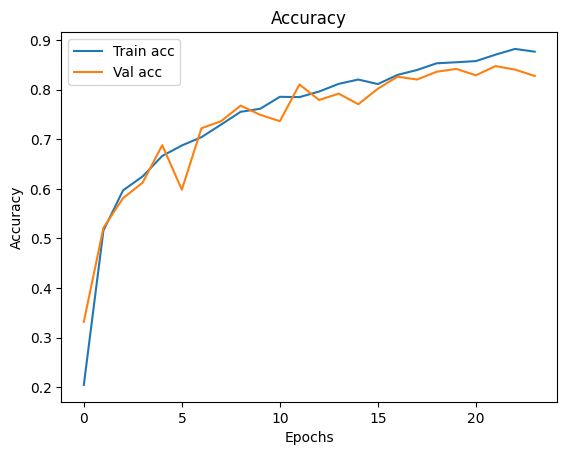

In [20]:
plt.plot(history.history["accuracy"],label="Train acc")
plt.plot(history.history["val_accuracy"],label="Val acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

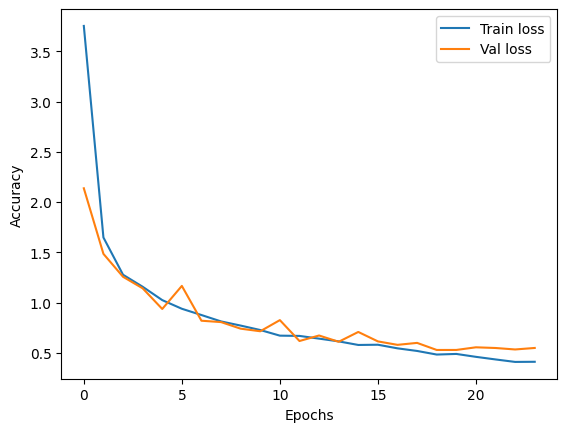

In [21]:
plt.plot(history.history["loss"],label="Train loss")
plt.plot(history.history["val_loss"],label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Evaluate on Test Dataset

In [22]:
loss, acc = VGG_model.evaluate(test_data)
print(loss,acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.8168 - loss: 0.5788
0.5486069321632385 0.828000009059906


### Export The Label from Test Dataset

In [57]:
import numpy as np

# Get predictions and true labels
y_pred = []  # Store predictions
y_label = []  # Store true labels

for images, labels in test_data:
    # Predict for each batch
    batch_pred = tf.argmax(VGG_model(images, training=False), axis=1).numpy()  # Get predictions
    y_pred.extend(batch_pred)  # Add to prediction list
    
    # Process true labels
    if len(labels.shape) > 1:  # Check if labels are one-hot encoded
        batch_labels = tf.argmax(labels, axis=1).numpy()
    else:
        batch_labels = labels.numpy()
    y_label.extend(batch_labels)  # Add to label list

# Convert to NumPy arrays
y_pred = np.array(y_pred)
y_label = np.array(y_label)


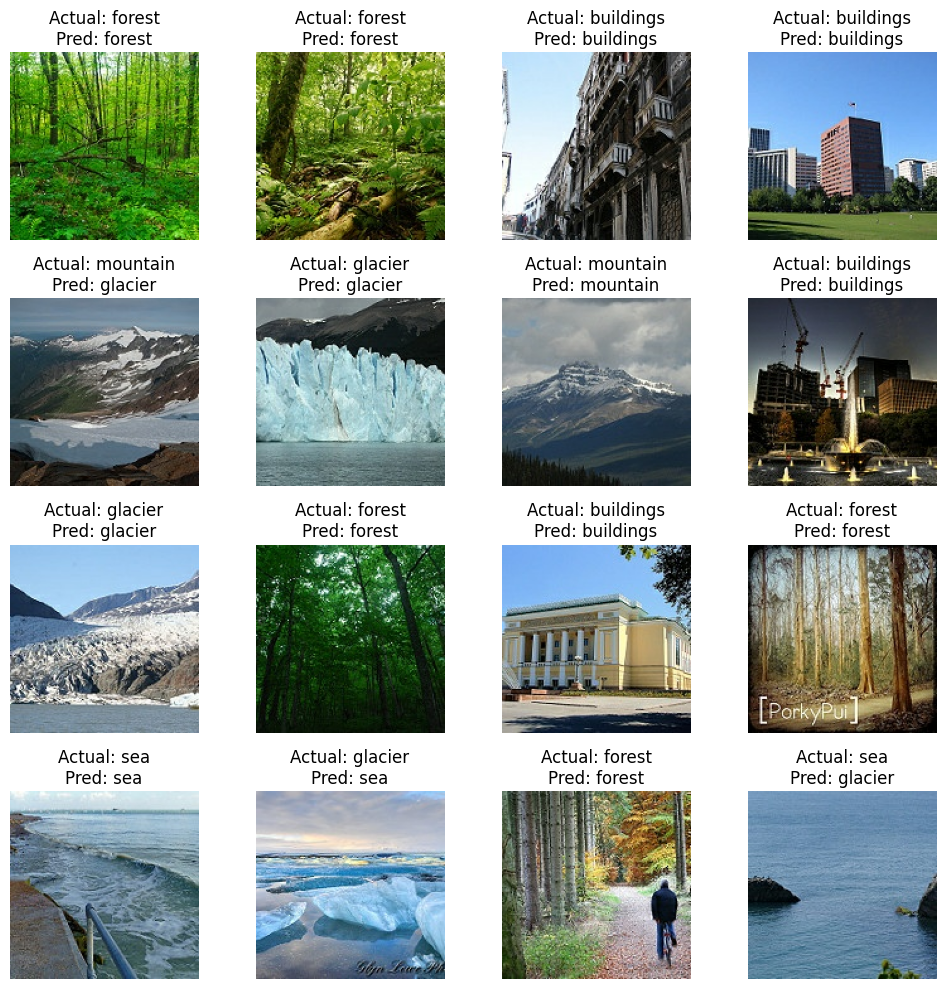

In [59]:

table = wandb.Table(columns=["Image", "True Label", "Predicted Label"])

y_pred = []  
y_label = []  
all_images = []  

for img_batch, labels in test_data:
    batch_pred = tf.argmax(VGG_model(img_batch, training=False), axis=1).numpy()
    y_pred.extend(batch_pred)
    batch_labels = tf.argmax(labels, axis=1).numpy()
    y_label.extend(batch_labels)
    all_images.extend(img_batch.numpy())

y_pred = np.array(y_pred)
y_label = np.array(y_label)
all_images = np.array(all_images)


plt.figure(figsize=(10, 10))
for i in range(16):  
    ax = plt.subplot(4, 4, i + 1)
    img = (all_images[i] * 255).astype("uint8")  
    plt.imshow(img)
    plt.title(f"Actual: {class_names[y_label[i]]}\nPred: {class_names[y_pred[i]]}")
    plt.axis(False)

plt.tight_layout()
plt.show()


for i in range(16):
    table.add_data(
        wandb.Image(all_images[i]), 
        class_names[y_label[i]],     
        class_names[y_pred[i]]      
    )

run.log({"predictions_table": table})
run.finish()


### Evaluate Using Confusion Matrix

In [60]:
confusion_matrix = tf.math.confusion_matrix(
    y_label,
    y_pred,
    num_classes=len(class_names)
)
print("Confusion Matrix:")
print(confusion_matrix.numpy())

Confusion Matrix:
[[432   4   5  26   1  57]
 [  1 424  68   6   0   2]
 [  5  37 381   5   0   9]
 [ 26   8  11 405   1  59]
 [  7  44   6   2 409   6]
 [ 86   5   3  32   2 425]]


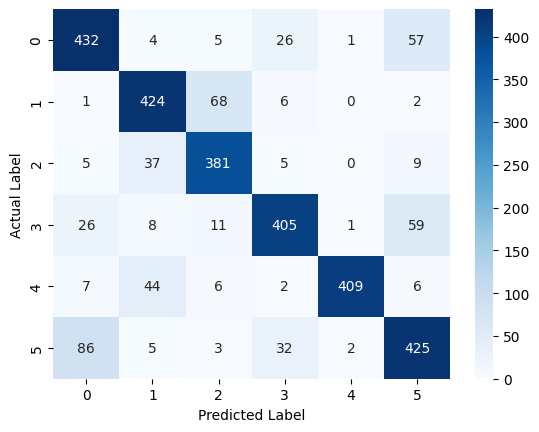

In [61]:
import seaborn as sns
plt.figure()
sns.heatmap(confusion_matrix.numpy(),annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [62]:
from sklearn.metrics import classification_report
report = classification_report(y_label,y_pred,target_names=[f"Class {i}" for i in range(len(class_names))])
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80       525
     Class 1       0.81      0.85      0.83       501
     Class 2       0.80      0.87      0.84       437
     Class 3       0.85      0.79      0.82       510
     Class 4       0.99      0.86      0.92       474
     Class 5       0.76      0.77      0.77       553

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

